### 평가

##### 분류모델 평가

1. 정확도(Accuracy score): 전체 샘플 중에서 올바르게 예측한 샘플의 비율
    - 데이터가 불균형한 경우 정확도는 비현실적인 성능 낼 수 있음
    - ex) label데이터에서 양성 1, 음성 9인 경우, 그리고 모델은 잘못된 학습으로 모두 부정 판단 했을 경우 그럼에도 성능은 0.9가 나올 것.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 잘못 학습된 모델 만들어보기1 (정확도 오류 보기 위함)
from sklearn.base import BaseEstimator

class MyTitanicClassifier(BaseEstimator):
# BaseEstimator(모델 클래스의 최상위 부모 클래스)를 상속받게 되면
#           MyTitanicClassifier 클래스가 모델 클래스 역할을 함

    def fit(self, X, y):
    # 훈련 메서드
        pass
        # 학습 안 시키고, 무조건 성별에 따라 생존, 사망을 판단하는 모델을 만들 것
    
    def predict(self, X):
    # 결과 예측 메서드
        pred = np.zeros((X.shape[0], 1))
        # X.shape[0] = sample 데이터의 개수
        # 0을 채워둠. 즉, 일단 모두 사망으로 predict 채워둠

        for i in range(X.shape[0]):
            sex = X['Sex'].iloc[i]
            # 'Sex' 열(Series형)의 i번째 행 값을 sex에 저장
            if sex == 0 :
                pred[i] = 1
            # 여성이면 무조건 생존한다는 예측값 저장
        return pred

In [ ]:
# 타이타닉 생존율 예측에 필요한 전처리 수행

# 전처리 -> 함수로 수행할 것! 메인 코드셀에선 호출만 할 것!

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


def fillna(df):
    # 결측치 처리 함수
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')

    return df

def drop_feature(df):
    # 필요없는 칼럼 제거 함수
    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
    return df

def encode_feature(df):
    # 라벨 인코딩 함수
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    
    df['Cabin'] = df['Cabin'].str[:1]
    # df['Cabin'].unique() 했을 때 Cabin은 규칙적이지만 값이 다양함 -> 첫 글자인 알파벳으로만 인코딩할 것(A, B, ..., T, ...)
    
    categories = ['Sex', 'Cabin', 'Embarked']

    for cate in categories:
        encoder = LabelEncoder()
        df[cate] = encoder.fit_transform(df[cate])
        # 칼럼마다 인코딩해야 하므로 객체 매번 생성

    # df['Sex'] = encoder.fit_transform(df['Sex'])
    # df['Cabin'] = encoder.fit_transform(df['Cabin'])
    # df['Embarked'] = encoder.fit_transform(df['Embarked'])
    
    return df


def scaling_feature(train_data, test_data):
    # 특성 스케일링
    from sklearn.preprocessing import RobustScaler
    rb_sc = RobustScaler()

    rb_sc.fit(train_data)
    train_scaled = rb_sc.transform(train_data)
    test_scaled = rb_sc.transform(test_data)
    
    return train_scaled, test_scaled


In [64]:
from sklearn.model_selection import train_test_split

# 데이터 로드
data = pd.read_csv('./data/titanic.csv')

# 특성-라벨 데이터 분리
X = data.drop('Survived', axis=1)
y = data['Survived']

# 전처리(결측치 처리, 필요없는 특성 제거, 라벨인코딩)
X = fillna(X)
X = drop_feature(X)
X = encode_feature(X)

# 훈련 - 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 스케일링
# X_train_scaled, X_test_scaled = scaling_feature(X_train, X_test)


In [38]:
# 예측, 정확도 평가
from sklearn.metrics import accuracy_score

# 모델 훈련
my_clf = MyTitanicClassifier()
my_clf.fit(X_train, y_train)

# 에측
pred_train = my_clf.predict(X_train)
pred_test = my_clf.predict(X_test)

# 평가
print(f'train데이터 평가: {accuracy_score(y_train, pred_train)}, test 데이터 평가: {accuracy_score(y_test, pred_test)}')
# train데이터 평가: 0.7874251497005988, test 데이터 평가: 0.7847533632286996
# 훈련을 pass했는데도 꽤 높은 평가지표가 나옴. 

train데이터 평가: 0.7874251497005988, test 데이터 평가: 0.7847533632286996


In [39]:
data.groupby('Survived')['Sex'].value_counts()

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: count, dtype: int64

##### 혼동 행렬 (Confusion Matrix)

|               | 예측 값 부정 (Negative) | 예측 값 긍정 (Positive) |
|---------------|------------------------|------------------------|
| 실제 값 부정 (Negative) | True Negative (TN)         | False Positive (FP)        |
| 실제 값 긍정 (Positive) | False Negative (FN)        | True Positive (TP)         |


![](https://d.pr/i/rtYBJv+)

In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [41]:
# 데이터 로드
from sklearn.datasets import load_digits

digits = load_digits()
# 손글씨 숫자 데이터

In [42]:
# 훈련-테스트 데이터 분리, 모델 학습, 예측, heatmap 시각화
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# cm = confusion_matrix(y_test, y_pred)

# sns.heatmap(cm, annot=True, fmt='d',
#              xticklabels=digits.target_names, yticklabels=digits.target_names)
# # confusion matrix 시각화. 라벨 수만큼 늘릴 수 있음

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

- 정밀도(Precision)
    - 양성이라고 예측한 것(TP+FP) 중에서 실제 양성(TP)일 확률
    - 정밀도가 중요한 지표인 경우: 음성인 데이터를 양성으로 예측하면 안 되는 경우 (ex. 스팸메일 분류 등)

In [ ]:
# 타이타닉 예측값
matrix = confusion_matrix(y_test, pred_test)
matrix

array([[112,  22],
       [ 26,  63]])

In [ ]:
# 정밀도
p_score = 63/85
p_score, precision_score(y_test, pred_test)
# 같은 값.

(0.7411764705882353, 0.7411764705882353)

- 재현율 (Recall)
    - 실제 긍정(TP+FN)인 것 중에 양성으로 예측(TP)한 확률
    - 재현율이 중요한 경우: 양성인 데이터를 음성으로 에측하면 안 되는 경우 (암 진단 등)

In [ ]:
# 재현율
r_score = 63/(26+63)
r_score, recall_score(y_test, pred_test)

# 정밀도보다 적은 점수.

(0.7078651685393258, 0.7078651685393258)

In [49]:
# 분류 평가 지표(혼동 행렬, 정확도, 정밀도, 재현율) 출력 함수 생성
def evaluate_binary_classification(y_true, y_pred):
    print('혼동 행렬\n', confusion_matrix(y_true, y_pred))
    print('정확도:', accuracy_score(y_true, y_pred))
    print('정밀도:', precision_score(y_true, y_pred))
    print('재현율:', recall_score(y_true, y_pred))

In [50]:
evaluate_binary_classification(y_test, pred_test)

혼동 행렬
 [[112  22]
 [ 26  63]]
정확도: 0.7847533632286996
정밀도: 0.7411764705882353
재현율: 0.7078651685393258


In [52]:
# 잘못 학습된 모델 만들어보기2
# 모두 사망했다고 예측

class MyDeathClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.zeros((X.shape[0], 1))

In [ ]:
# 학습
my_clf = MyDeathClassifier()
my_clf.fit(X_train, y_train)

# 평가
train_pred = my_clf.predict(X_train)
test_pred = my_clf.predict(X_test)

# 평가 지표 함수 호출
evaluate_binary_classification(y_train, train_pred)
evaluate_binary_classification(y_test, test_pred)

# 예측값이 무조건 음성. TN, FN
# 즉, 정확도는 0.62가 나오나 정밀도, 재현율은 0
# 정밀도, 재현율의 분자값은 TP=0이기 때문

혼동 행렬
 [[415   0]
 [253   0]]
정확도: 0.6212574850299402
정밀도: 0.0
재현율: 0.0
혼동 행렬
 [[134   0]
 [ 89   0]]
정확도: 0.600896860986547
정밀도: 0.0
재현율: 0.0


c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
# 제대로 된 모델.
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train, y_train)

train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

# 평가 지표 함수 호출
evaluate_binary_classification(y_train, train_pred)
evaluate_binary_classification(y_test, test_pred)

혼동 행렬
 [[350  60]
 [ 77 181]]
정확도: 0.7949101796407185
정밀도: 0.7510373443983402
재현율: 0.7015503875968992
혼동 행렬
 [[117  22]
 [ 23  61]]
정확도: 0.7982062780269058
정밀도: 0.7349397590361446
재현율: 0.7261904761904762


c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 정밀도와 재현율의 trade-off (FP, FN은 반비례)
    (각각 0, 1이라 예측했는데 모두 정답 못맞춤(False))
    - 분류 결정 임계치(threshold)를 낮추면? positive라고 예측할 확률이 높아짐
        -> FP가 커지고 FN이 낮아짐 -> 정밀도 낮아지고 재현율 높아짐
    - 분류 결정 임계치를 높이면? positive라고 예측할 확률이 낮아짐
        -> FP가 낮아지고 FN이 커짐 -> 정밀도 높아지고 재현율 낮아짐

In [ ]:
pred_proba = lr.predict_proba(X_test)
print(pred_proba[:7])

pred = lr.predict(X_test)
print(pred[:7])

[[0.83741741 0.16258259]
 [0.88842911 0.11157089]
 [0.92060845 0.07939155]
 [0.0559761  0.9440239 ]
 [0.29857741 0.70142259]
 [0.50640704 0.49359296]
 [0.09195634 0.90804366]]
[0 0 0 1 1 0 1]


In [ ]:
# Binarizer

from sklearn.preprocessing import Binarizer

temp_X = [[1, -1, 2], [2, 0, 0.8], [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1)
# 임게치 설정해 이진 분류 실행
# 임계치 '초과'할 때 1. 이하면 0 반환
adj_X = binarizer.fit_transform(temp_X)
adj_X

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 1.]])

In [72]:
pred_proba[:, 1].reshape(-1, 1)

array([[0.16258259],
       [0.11157089],
       [0.07939155],
       [0.9440239 ],
       [0.70142259],
       [0.49359296],
       [0.90804366],
       [0.92676311],
       [0.59025838],
       [0.71821447],
       [0.093393  ],
       [0.72823646],
       [0.12653829],
       [0.89822892],
       [0.96329751],
       [0.7548233 ],
       [0.14063724],
       [0.24066522],
       [0.09260111],
       [0.3645661 ],
       [0.32401921],
       [0.93833898],
       [0.12653675],
       [0.42631418],
       [0.69269295],
       [0.89893898],
       [0.10296443],
       [0.69219738],
       [0.82199638],
       [0.61515884],
       [0.14490342],
       [0.64346534],
       [0.11858111],
       [0.49498619],
       [0.08382049],
       [0.59058679],
       [0.06926464],
       [0.24435557],
       [0.26728943],
       [0.1047556 ],
       [0.25335262],
       [0.18804349],
       [0.11234114],
       [0.05435915],
       [0.88741259],
       [0.1116091 ],
       [0.1116091 ],
       [0.950

In [ ]:
# # Binarizer 이용해 타이타닉 데이터로 이진 분류

# 1(생존)일 확률만 가져오고 + 배치 차원 추가 (2차원으로 만듦)
predict_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=0.5)
custom_pred = binarizer.fit_transform(predict_proba_1)
evaluate_binary_classification(y_test, custom_pred)

binarizer = Binarizer(threshold=0.6)
custom_pred = binarizer.fit_transform(predict_proba_1)
evaluate_binary_classification(y_test, custom_pred)

# 임계치를 0.6으로 올리니 정밀도 오르고 재현율 내려감. FP가 내려가고 FN이 올라갔기 때문

혼동 행렬
 [[117  22]
 [ 23  61]]
정확도: 0.7982062780269058
정밀도: 0.7349397590361446
재현율: 0.7261904761904762
혼동 행렬
 [[124  15]
 [ 30  54]]
정확도: 0.7982062780269058
정밀도: 0.782608695652174
재현율: 0.6428571428571429


In [ ]:
# 임계치 별 평가 결과 확인
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def evaluate_by_threshold(y_true, y_pred, thresholds):
    
    for thre in thresholds:
        bi = Binarizer(threshold=thre)
        custom_pred = bi.fit_transform(y_pred)
        evaluate_binary_classification(y_true, custom_pred)

evaluate_by_threshold(y_test, predict_proba_1, thresholds)
# 임계치 올라갈수록 정밀도 올라감, 재현율 내려감

혼동 행렬
 [[109  30]
 [ 19  65]]
정확도: 0.7802690582959642
정밀도: 0.6842105263157895
재현율: 0.7738095238095238
혼동 행렬
 [[114  25]
 [ 19  65]]
정확도: 0.8026905829596412
정밀도: 0.7222222222222222
재현율: 0.7738095238095238
혼동 행렬
 [[117  22]
 [ 23  61]]
정확도: 0.7982062780269058
정밀도: 0.7349397590361446
재현율: 0.7261904761904762
혼동 행렬
 [[121  18]
 [ 23  61]]
정확도: 0.8161434977578476
정밀도: 0.7721518987341772
재현율: 0.7261904761904762
혼동 행렬
 [[124  15]
 [ 30  54]]
정확도: 0.7982062780269058
정밀도: 0.782608695652174
재현율: 0.6428571428571429


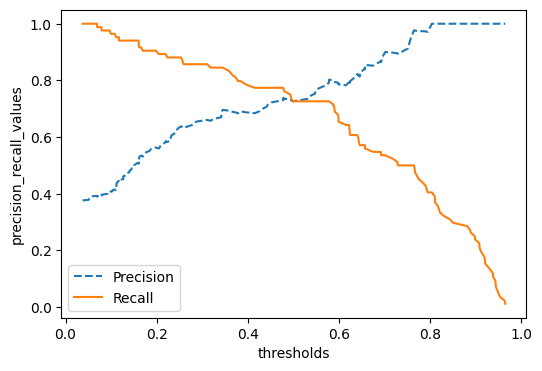

In [ ]:
# 정밀도-재현율 변화 과정 시각화
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, predict_proba_1)
# 실제값과 양성이라고 예측한 확률값을 받으면 각 thresholds에 따른 precision과 recall을 두 개 반환.

precisions.shape, recalls.shape, thresholds.shape
# thresholds만 행 개수가 1개 적음.
# precisions는 마지막에 1 하나, recalls는 마지막에 0 하나가 추가되어있기 때문

# 기준 thresholds는 211개.
# 이때 정밀도와 재현율에 각각 추가된 마지막 값은 극단적 임계값 설정에 대한 계산 결과.
# 따라서 정밀도는 마지막에 1 추가 (임계값 매우 낮아 모두 양성으로 예측된 경우)
#       재현율은 마지막에 0 추가 (임계값 매우 높아 모두 음성으로 예측된 경우)

# 시각화
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions[:-1], linestyle='--', label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
# [:-1]: precisions, recalls에 있던 마지막 한 값을 뺌

plt.xlabel('thresholds')
plt.ylabel('precision_recall_values')
plt.legend()
plt.show()

- F1-score
    - 정밀도와 재현율을 결합한 지표

In [82]:
from sklearn.metrics import f1_score

f1_score(y_test, test_pred)

0.7305389221556886

In [83]:
# 분류 평가 지표(혼동 행렬, 정확도, 정밀도, 재현율, f1_score) 출력 함수 생성
def evaluate_binary_classification(y_true, y_pred):
    print('혼동 행렬\n', confusion_matrix(y_true, y_pred))
    print('정확도:', accuracy_score(y_true, y_pred))
    print('정밀도:', precision_score(y_true, y_pred))
    print('재현율:', recall_score(y_true, y_pred))
    print('f1-score:', f1_score(y_true, y_pred))

In [ ]:
# 임계치 별 평가 결과 확인
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

def evaluate_by_threshold(y_true, y_pred, thresholds):
    
    for thre in thresholds:
        bi = Binarizer(threshold=thre)
        custom_pred = bi.fit_transform(y_pred)
        evaluate_binary_classification(y_true, custom_pred)

evaluate_by_threshold(y_test, predict_proba_1, thresholds)
# f1_score는 일정한 증가나 감소 보이지 않음
# 0.55일 때 가장 큰 값

혼동 행렬
 [[109  30]
 [ 19  65]]
정확도: 0.7802690582959642
정밀도: 0.6842105263157895
재현율: 0.7738095238095238
f1-score: 0.7262569832402235
혼동 행렬
 [[114  25]
 [ 19  65]]
정확도: 0.8026905829596412
정밀도: 0.7222222222222222
재현율: 0.7738095238095238
f1-score: 0.7471264367816092
혼동 행렬
 [[117  22]
 [ 23  61]]
정확도: 0.7982062780269058
정밀도: 0.7349397590361446
재현율: 0.7261904761904762
f1-score: 0.7305389221556886
혼동 행렬
 [[121  18]
 [ 23  61]]
정확도: 0.8161434977578476
정밀도: 0.7721518987341772
재현율: 0.7261904761904762
f1-score: 0.7484662576687117
혼동 행렬
 [[124  15]
 [ 30  54]]
정확도: 0.7982062780269058
정밀도: 0.782608695652174
재현율: 0.6428571428571429
f1-score: 0.7058823529411765
혼동 행렬
 [[130   9]
 [ 36  48]]
정확도: 0.7982062780269058
정밀도: 0.8421052631578947
재현율: 0.5714285714285714
f1-score: 0.6808510638297872
혼동 행렬
 [[134   5]
 [ 39  45]]
정확도: 0.8026905829596412
정밀도: 0.9
재현율: 0.5357142857142857
f1-score: 0.6716417910447762


##### ROC Curve - AUC
- ROC Curve (Receiver Operation Characteristic Curve, 수신자 조작 특성 커브)
    - x축: FPR (False Positive Rate), 실제 음성을 잘못 예측한 비율
        - FPR = FP / (FP + TN)
    - y축: TPR (True Positive Rate), recall score
        - TPR = TP / (FN + TP)
- AUC (Area Under Curve) : ROC 곡선 아래 면적 (1에 가까울수록 성능 좋음)

In [ ]:
from sklearn.metrics import roc_curve

y_true_sample = np.array([0, 0, 1, 1])
y_pred_sample = np.array([0.1, 0.4, 0.35, 0.8])

fpr, tpr, thresholds = roc_curve(y_true_sample, y_pred_sample)
# 해당 메서드는 FPR, TPR, thresholds 배열 세 개를 반환함
fpr, tpr, thresholds
# fpr, tpr은 극단으로 큰 값을 하나씩 더 저장. thresholds에 저장된 inf는 임의의 '큰 값'

(array([0. , 0. , 0.5, 0.5, 1. ]),
 array([0. , 0.5, 0.5, 1. , 1. ]),
 array([ inf, 0.8 , 0.4 , 0.35, 0.1 ]))

In [89]:
X_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
495,3,1,29.699118,0,0,14.4583,7,0
648,3,1,29.699118,0,0,7.5500,7,3
278,3,1,7.000000,4,1,29.1250,7,2
31,1,0,29.699118,1,0,146.5208,1,0
255,3,0,29.000000,0,2,15.2458,7,0
...,...,...,...,...,...,...,...,...
167,3,0,45.000000,1,4,27.9000,7,3
306,1,0,29.699118,0,0,110.8833,7,0
379,3,1,19.000000,0,0,7.7750,7,3
742,1,0,21.000000,2,2,262.3750,1,0


c:\Users\Playdata\AppData\Local\anaconda3\envs\ml_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


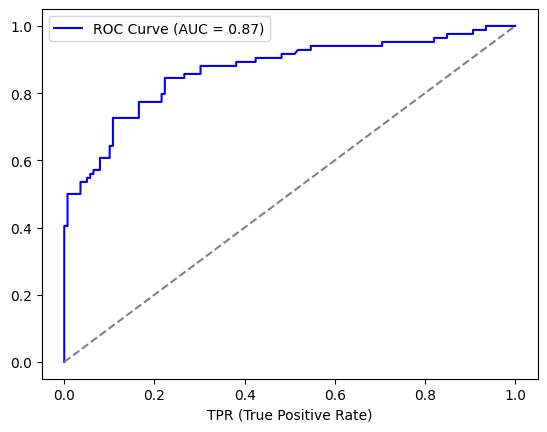

In [ ]:
from sklearn.metrics import auc

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
# 1번 클래스, 즉, 양성 클래스에 대한 확률만 추출해 y_pred_proba에 저장

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
# 면적이 0.87

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
# 기울기가 1인 보조선도 함께 나타냄

plt.xlabel('FPR (False Positive Rate)')
plt.xlabel('TPR (True Positive Rate)')
plt.legend()
plt.show()

---
### 회귀모델 평가

In [91]:
# 샘플 데이터 생성
y_true = [3, 0.5, 2, 7]
y_pred = [2.5, 0, 2, 9]

In [ ]:
from sklearn.metrics import mean_squared_error             # MSE (평균 제곱 오차)
from sklearn.metrics import root_mean_squared_error        # RMSE (제곱 평균 제곱근 오차)
from sklearn.metrics import mean_absolute_error            # MAE (평균 절대 오차)
from sklearn.metrics import mean_squared_log_error         # MSLE (평균 제곱 로그 오차)
from sklearn.metrics import root_mean_squared_log_error    # RMSLE (제곱 평균 제곱근 로그 오차)
from sklearn.metrics import r2_score                       # R^2 결정계수

print(mean_squared_error(y_true, y_pred))

print(root_mean_squared_error(y_true, y_pred))
print(mean_absolute_error(y_true, y_pred))

print(mean_squared_log_error(y_true, y_pred))
# 상용 로그 취한 값. 원래 값에 +1을 해 -무한대 및 음수값이 나오는 걸 방지함
print(root_mean_squared_log_error(y_true, y_pred))

print(r2_score(y_true, y_pred))

1.125
1.0606601717798212
0.75
0.058006407800631835
0.2408451946803835
0.8059299191374663
